In [1]:
import torch
import torchaudio
import torchvision
from datasets import load_dataset
from IPython.display import Audio
from torchvision.transforms import ToPILImage

/home/dgj335/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
device = "cuda"
class Config: pass
config = Config()
config.batch_size = 16
config.num_workers = 12
config.grad_accum_steps = 1
config.plot_update = 64
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 2000

config.length_samples = 2**20
config.channels = 2
config.embed_dim = 192
config.patch_size = 4096
config.depth = 12

In [3]:
train_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='train')
valid_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='validation')

In [4]:
L = config.length_samples
C = config.channels
crop = torchvision.transforms.RandomCrop((2,L))
def collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = crop(audio)
    return x[:,:,0,:], x[:,:,1,:]

In [5]:
valid_batch = valid_dataset[:4]
valid_batch = [dict(zip(valid_batch.keys(), values)) for values in zip(*valid_batch.values())]
x_valid, v_valid = collate_fn(valid_batch)
x_valid = x_valid.to(device)
v_valid = v_valid.to(device)

In [6]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X)

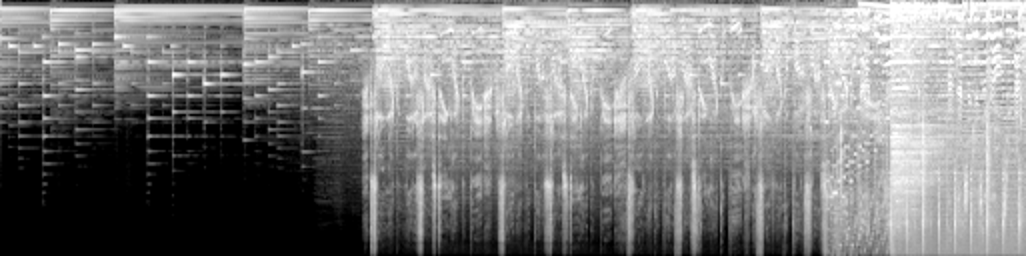

In [7]:
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=4096,
).to(device)
SG = make_spectrogram(x_valid[0,0].to(device))
SG.resize((1026,256))

In [8]:
import torch
import torch.nn as nn
from einops import rearrange

class AudioCNN(nn.Module):
    def __init__(self, channels, embed_dim, patch_size, depth):
        super(AudioCNN, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth

        self.conv_stem = nn.Conv1d(
            in_channels=self.channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding=0,
        )

        self.conv_layers = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.embed_dim,
                out_channels=self.embed_dim,
                kernel_size=11,
                stride=1,
                padding=5,
                padding_mode='reflect'
            ) for _ in range(self.depth)
        ])

        self.linear_projection = nn.Linear(self.embed_dim, self.patch_size * self.channels)

    def forward(self, x):
        x = self.conv_stem(x)
        for conv_layer in self.conv_layers:
            residual = x
            x = conv_layer(x)
            x = x + residual
        x = rearrange(x, 'b c l -> b l c')
        x = self.linear_projection(x)
        x = rearrange(x, 'b l (p c) -> b c (l p)', p=self.patch_size, c=self.channels)
        return x


In [9]:
model = AudioCNN(
    channels = config.channels,
    embed_dim = config.embed_dim,
    patch_size = config.patch_size,
    depth = config.depth
).to(device)    

In [10]:
pred = model(x_valid)

In [11]:
pred.shape

torch.Size([4, 2, 1048576])

In [13]:
v_valid.shape

torch.Size([4, 2, 1048576])